# `Exact` explainer

This notebooks demonstrates how to use the Exact explainer on some simple datasets. The Exact explainer is model-agnostic, so it can compute Shapley values and Owen values exactly (without approximation) for any model. However, since it completely enumerates the space of masking patterns it has $O(2^M)$ complexity for Shapley values and $O(M^2)$ complexity for Owen values on a balanced clustering tree for M input features.

Because the exact explainer knows that it is fully enumerating the masking space it can use optimizations that are not possible with random sampling based approaches, such as using a [grey code](https://en.wikipedia.org/wiki/Gray_code) ordering to minimize the number of inputs that change between successive masking patterns, and so potentially reduce the number of times the model needs to be called.

In [1]:
import shap
import xgboost

# get a dataset on income prediction
X,y = shap.datasets.adult()

# train an XGBoost model (but any other model type would also work)
model = xgboost.XGBClassifier()
model.fit(X, y);

## Tabular data with independent (Shapley value) masking

In [2]:
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:100])

# get just the explanations for the positive class
shap_values = shap_values[...,1]

Exact explainer: 101it [00:12,  8.13it/s]                        


### Plot a global summary

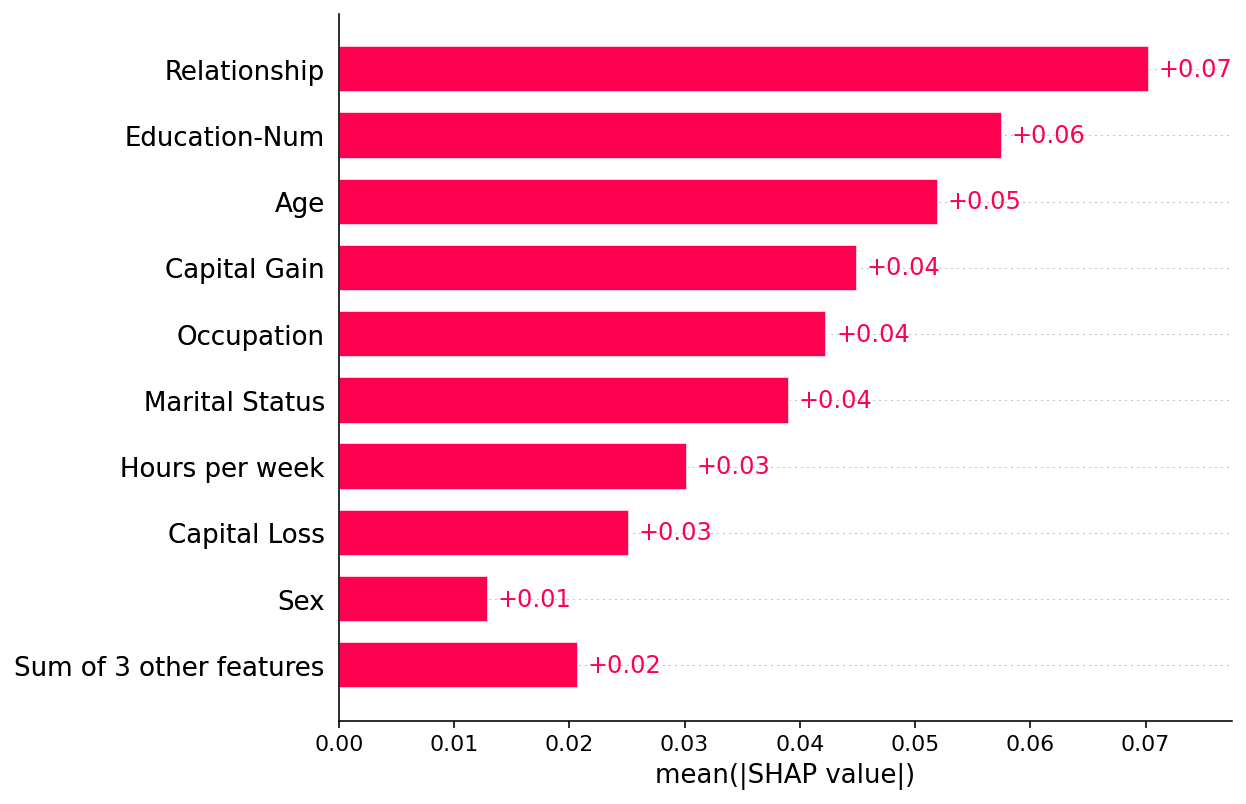

In [3]:
shap.plots.bar(shap_values)

### Plot a single instance

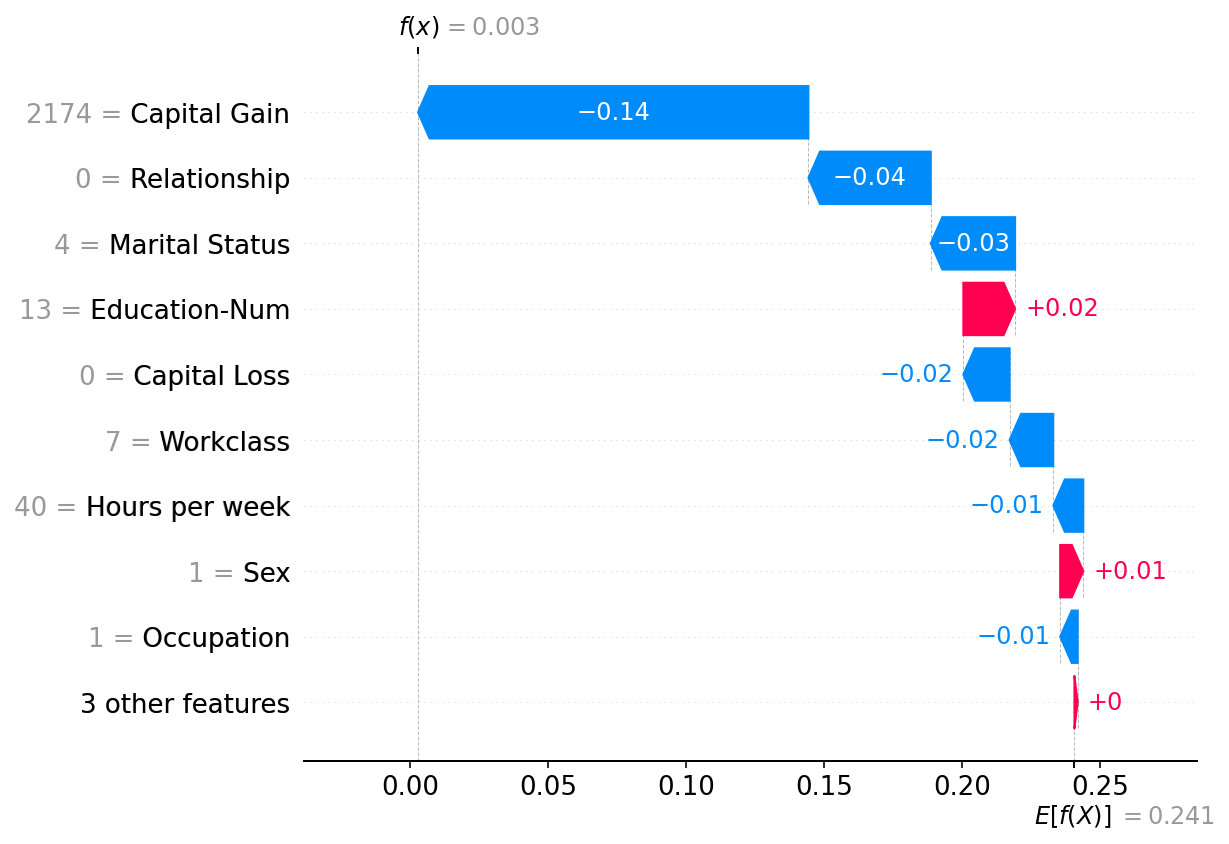

In [4]:
shap.plots.waterfall(shap_values[0])

## Tabular data with partition (Owen value) masking

While Shapley values result from treating each feature independently of the other features, it is often useful to enforce a structure on the model inputs. Enforcing such a structure produces a structure game (i.e. a game with rules about valid input feature coalitions), and when that structure is a nest set of feature grouping we get the Owen values as a recursive application of Shapley values to the group. In SHAP, we take the partitioning to the limit and build a binary herarchial clustering tree to represent the structure of the data. This structure could be chosen in many ways, but for tabular data it is often helpful to build the structure from the redundancy of information between the input features about the output label. This is what we do below:

In [5]:
# build a clustering of the features based on shared information about y
clustering = shap.utils.hclust(X, y)

In [6]:
# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X, clustering=clustering)

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict_proba, masker)
shap_values2 = explainer(X[:100])

# get just the explanations for the positive class
shap_values2 = shap_values2[...,1]

### Plot a global summary

Note that only the Relationship and Marital status features share more that 50% of their explanation power (as measured by R2) with each other, so all the other parts of the clustering tree are removed by the the default `clustering_cutoff=0.5` setting:

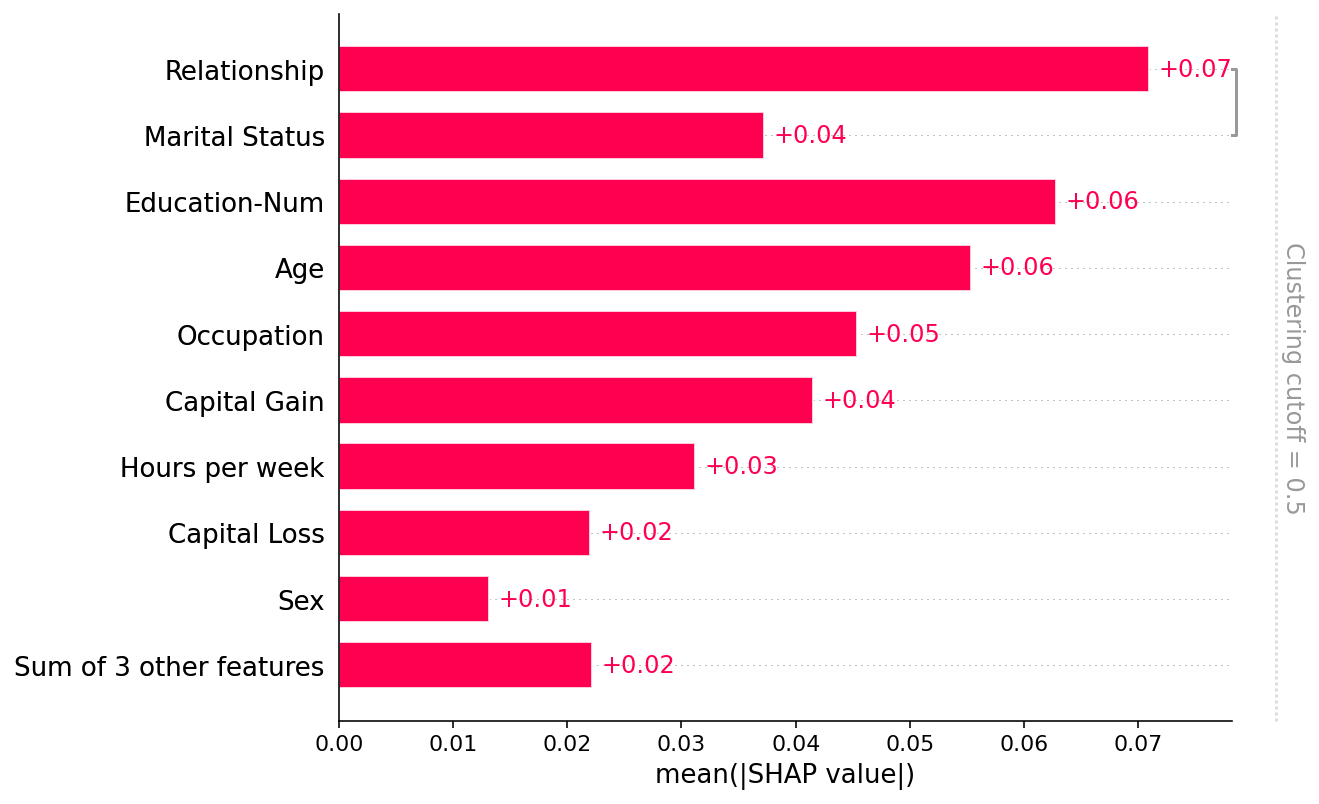

In [7]:
shap.plots.bar(shap_values2)

### Plot a single instance

Note that there is a strong similarity between the explanation from the Independent masker above and the Partition masker here. In general the distinctions between these methods for tabular data are not large, though the Partition masker allows for much faster runtime and potentially more realistic manipulations of the model inputs (since groups of clustered features are masked/unmasked together).

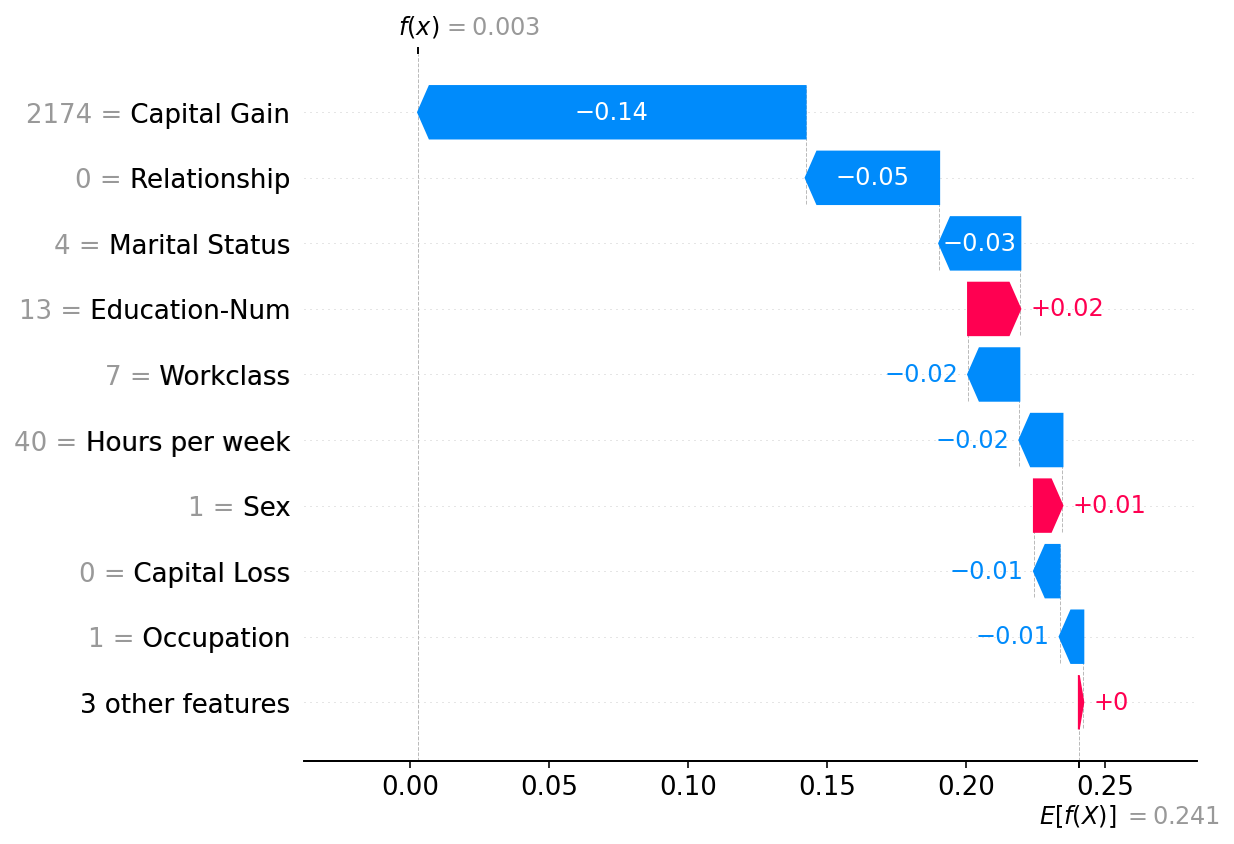

In [8]:
shap.plots.waterfall(shap_values2[0])